# notes on fitting

I'm building a velocity-depth trend and I need the resulting trendline to be anchored to the velocity aorund the sea bottom, otherwise I may end up with some crazy ass trends.

I have found a solution on [stackexchange](http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points) but I wonder if there's anything simpler (and that I may be able to actually understand).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

This is the function that does the magic (taken from 
<http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points>):

In [2]:
def solve_ns(A, b): return np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
def clsq(A, b, C, d):
    """An 'exact' constrained least squared solution of Ax= b, s.t. Cx= d"""
    from scipy.linalg import qr
    p= C.shape[0]
    Q, R= qr(C.T)
    xr, AQ= np.linalg.solve(R[:p].T, d), np.dot(A, Q)
    xaq= solve_ns(AQ[:, p:], b- np.dot(AQ[:, :p], xr))
    return np.dot(Q[:, :p], xr)+ np.dot(Q[:, p:], xaq)
def cpf(x, y, x_c, y_c, n):
    """Constrained polynomial fit based on clsq solution."""
    from numpy.polynomial.polynomial import Polynomial as P, polyvander as V
    x_c = np.array([x_c])
    y_c = np.array([y_c])
    return P(clsq(V(x, n), y, V(x_c, n), y_c))

An example on how to use it.

Let's pretend that the water depth is 200m and that the velocity of the first meters of sediments is 1600 m/s. This pair of points will be our 'anchor'.

In [15]:
L=pd.read_csv('qsiwell2_frm.csv')

vp=L.VP.values
z=L.DEPTH.values
mask = np.isfinite(vp) # mask to select valid (i.e., not NaNs) velocity samples

# anchor points
z0=1000
vp0=1600
vs0=800
rho0=1.5

# final trends will be calculated over zfit that goes from z0=seabottom to 3000m
zfit = np.linspace(z0,3000,100)

# simple linear fit
fit0 = np.polyfit(z[mask],vp[mask],1)
trend0 = np.polyval(fit0,zfit)

# constrained polynomial fit
p = cpf(z[mask], vp[mask], z0 , vp0, 1)
trend1 = p(zfit)

Plots the velocity log with the two trendlines and the anchor point at the seabottom:

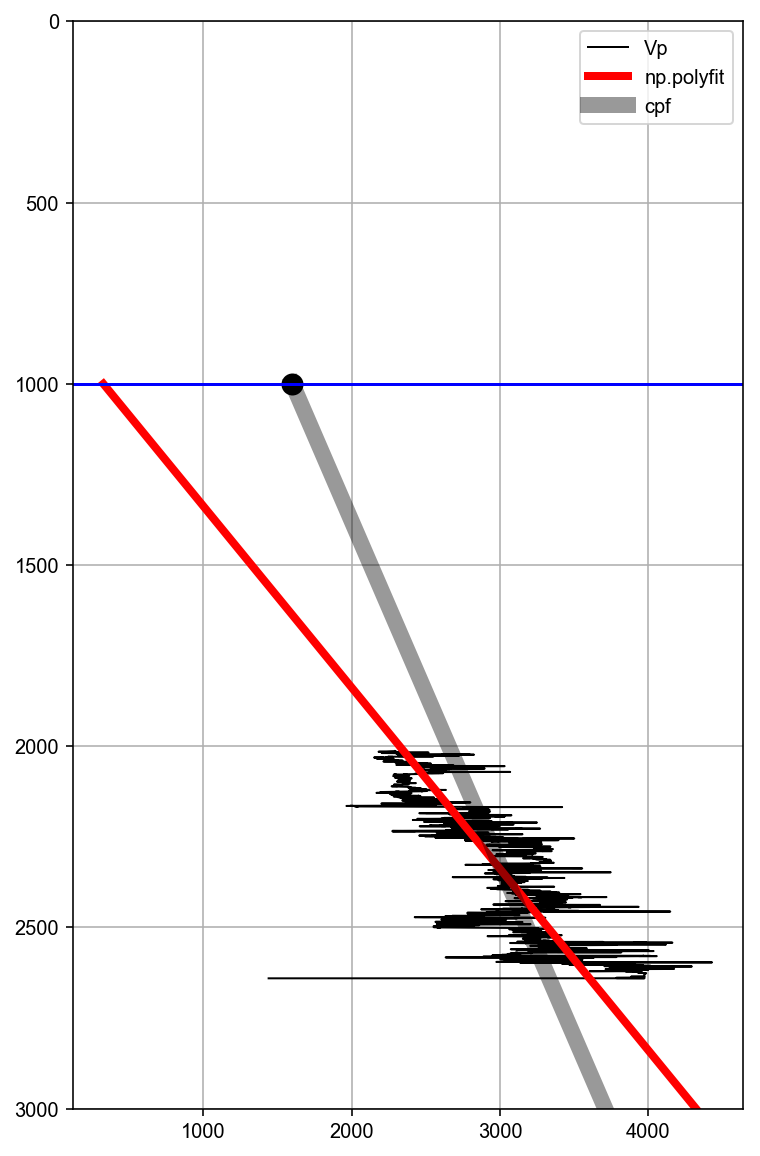

In [4]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',lw=1,label='Vp')
plt.plot(trend0,zfit,'r',lw=4,label='np.polyfit')
plt.plot(trend1,zfit,'k',alpha=0.4,lw=8,label='cpf')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='b')
plt.legend()
plt.grid()

# solutions and further doubts

Alright, so today (8th February 2017, the notes above were written yesterday) I managed to solve all the problems related to calculations and Python/Numpy functions to use. But there's still things that are not very clear to me, let me show what are the remaining doubts.

### alternative/easier solution for constrained linear fit

Basically instead of the overly complicated `cpf` function above which I don't even understand, is there another way to constrain a linear fit to cross certain points?

...well there is:

In [5]:
# constrained linear fit
m = np.linalg.lstsq(z[mask][:,None]-z0,vp[mask][:,None]-vp0)[0]
trend2 = m.flatten()*(zfit-z0)+vp0

So `trend2` (yellow thin line below) gives exactly the same result as `cpf` (when `cpf` is run with degree=1):

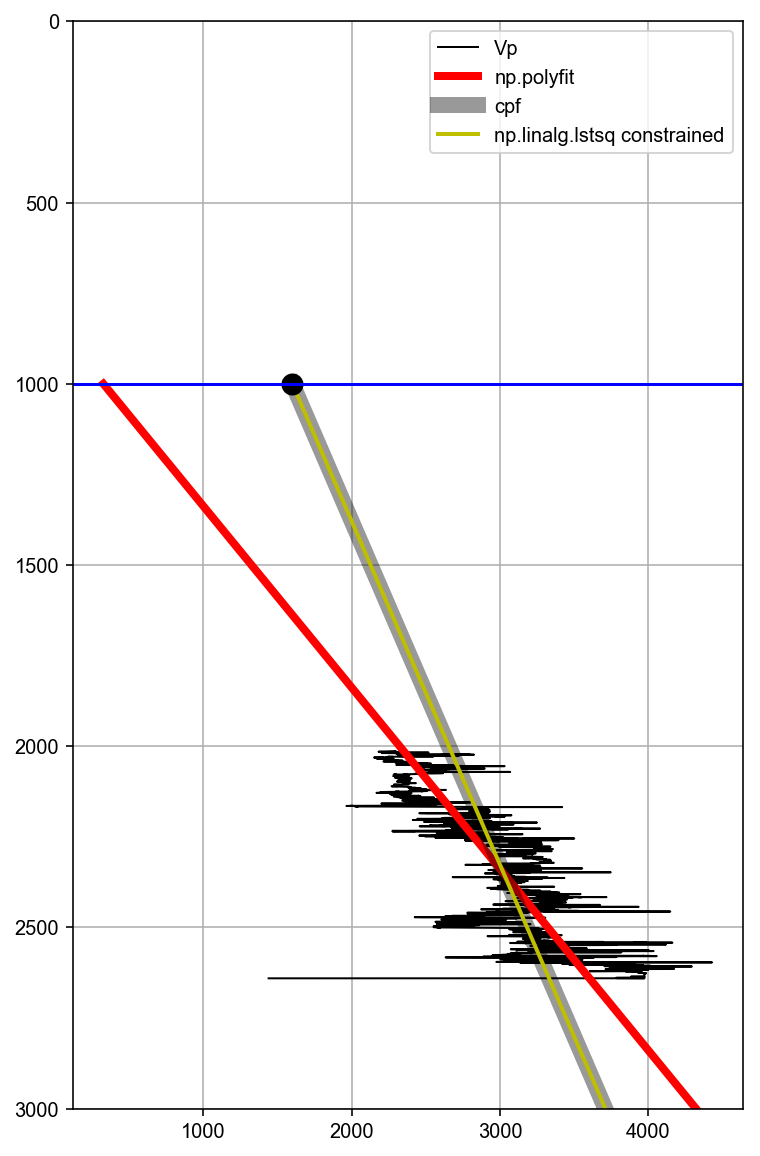

In [6]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',lw=1,label='Vp')
plt.plot(trend0,zfit,'r',lw=4,label='np.polyfit')
plt.plot(trend1,zfit,'k',alpha=0.4,lw=8,label='cpf')
plt.plot(trend2,zfit,'y',lw=2,label='np.linalg.lstsq constrained')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='b')
plt.legend(fontsize='medium')
plt.grid()

### non-linear trends

The elastic properties depth trends are almost certainly non-linear in real life; linear is a nice and easy approximation but almost certainly not true.

I can use `curve_fit` using arbitrary functions and modify the `sigma` vector to give more weight to a certain datapoint, so making sure that the fitted function crosses this datapoint (or at least is as close as possible).

The exponential function is the one usually seen on papers and books (_add references_):

$$ V = \frac{a}{1+c*e^{(-Z/b)}} $$

The meaning of the initial parameters given in the code below:

`curve_fit(fexp, z, vp, p0=(5000,2000,1), maxfev=9999)`

is that `p0[0]` = $a$ is the maximum velocity that you can reach, `p0[1]` = $b$ is a depth.

_I should mention that my old pal [Dario G](http://www.uwyo.edu/geolgeophys/faculty/dario-grana.html) helped me with understanding how to code and use this exponential function._

In [7]:
from scipy.optimize import curve_fit

def fpow(x, a, b):
    return a * np.power(x,b)

def flog(x, a, b):
    return a * np.log(x) + b

def fexp(z, a, b, c):
    return a / (1+c*np.exp(-z/b))

In [8]:
# to constrain curve_fit first I add the anchor point to the top of the log
# then create a sigma vector with a absurdly low value (=high weight)
# corresponding to this first point 
z1=np.insert(z[mask],0,z0)
vp1=np.insert(vp[mask],0,vp0)
sigma =np.ones(z1.size)
sigma[0] = 0.001

In [9]:
# constrained polynomial fit 2nd degree
p = cpf(z[mask], vp[mask], z0 , vp0, 2)
trend3 = p(zfit)

# curve_fit of function a/(1+c*exp(-z/z0))
pE, _ = curve_fit(fexp, z[mask], vp[mask], p0=(5000,2000,1), maxfev=9999)
trendE = fexp(zfit, *pE)
pEc, _ = curve_fit(fexp, z1, vp1, p0=(5000,2000,1), sigma=sigma, maxfev=9999)
trendEc = fexp(zfit, *pEc)

# curve_fit of function a*x**b
pP, _ = curve_fit(fpow, z[mask], vp[mask])
trendP = fpow(zfit, *pP)
pPc, _ = curve_fit(fpow, z1, vp1,sigma=sigma)
trendPc = fpow(zfit, *pPc)

# curve_fit of function a*log(x)+b
pL, _ = curve_fit(flog, z[mask], vp[mask])
trendL = flog(zfit, *pL)
pLc, _ = curve_fit(flog, z1, vp1,sigma=sigma)
trendLc = flog(zfit, *pLc)

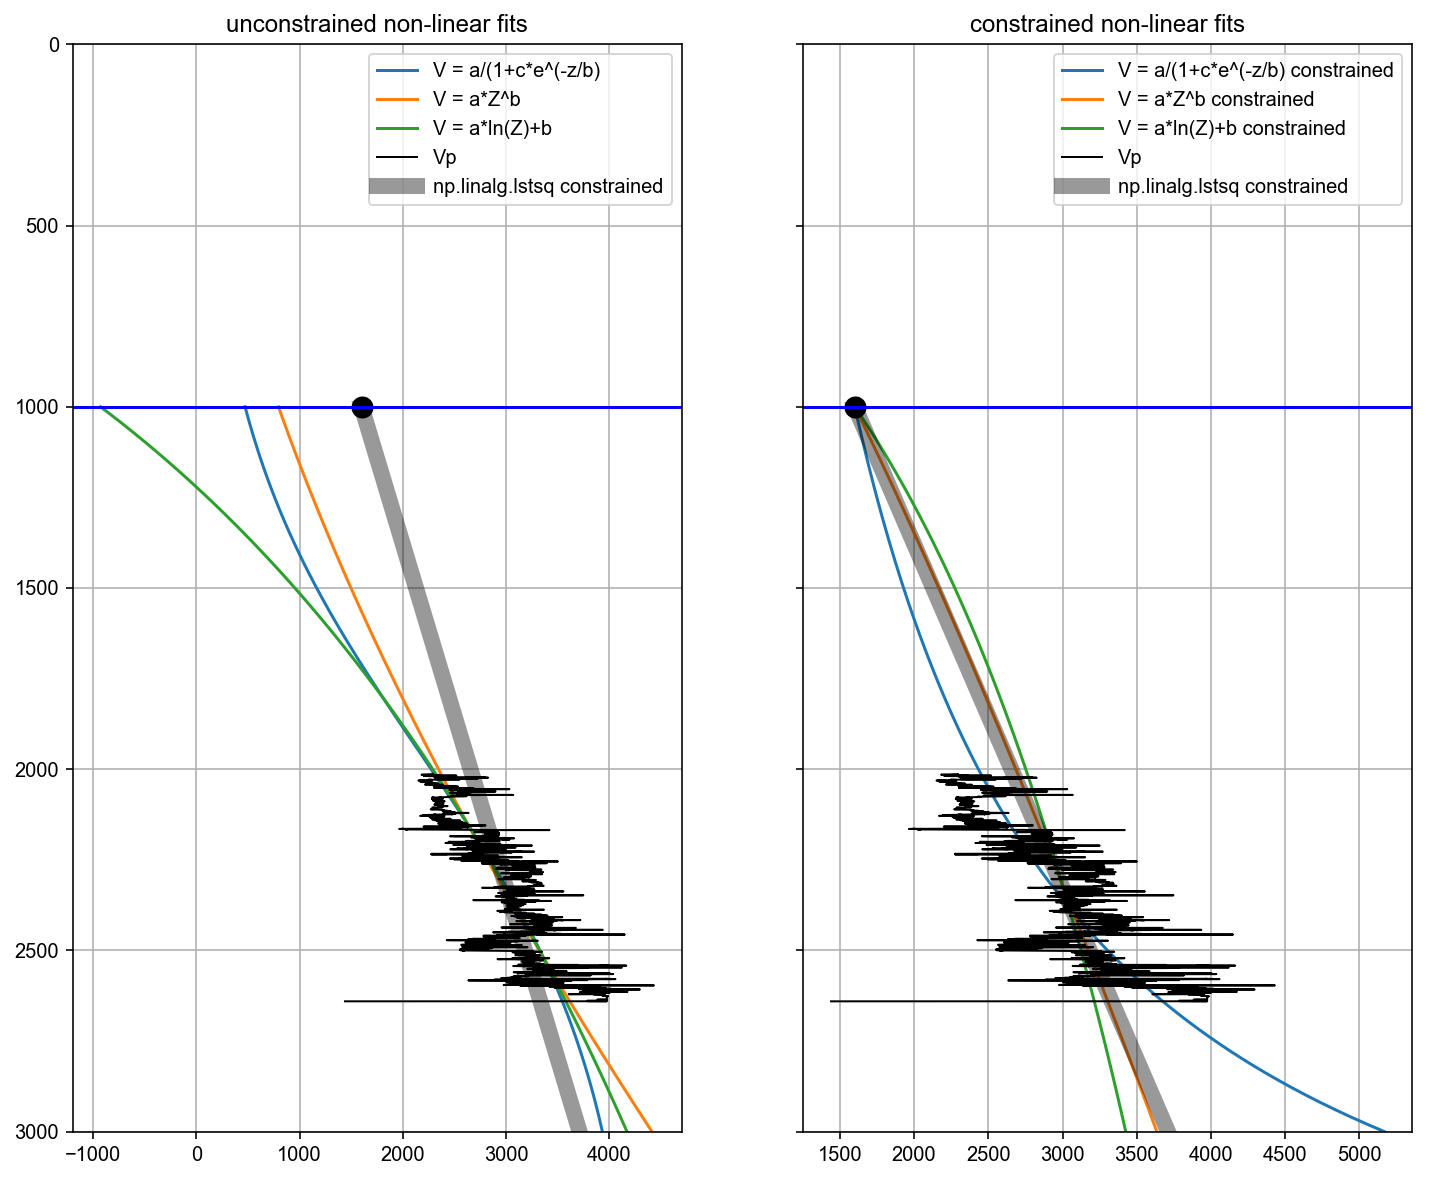

In [10]:
f, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(12,10))
ax[0].plot(trendE,zfit, label='V = a/(1+c*e^(-z/b)')
ax[0].plot(trendP,zfit, label='V = a*Z^b')
ax[0].plot(trendL,zfit, label='V = a*ln(Z)+b')
ax[1].plot(trendEc,zfit, label='V = a/(1+c*e^(-z/b) constrained')
ax[1].plot(trendPc,zfit, label='V = a*Z^b constrained')
ax[1].plot(trendLc,zfit, label='V = a*ln(Z)+b constrained')
ax[0].set_title('unconstrained non-linear fits')
ax[1].set_title('constrained non-linear fits')
for aa in ax:
    aa.plot(vp,z,'k',lw=1,label='Vp')
    aa.plot(trend2,zfit,'k',lw=8, alpha=0.4,label='np.linalg.lstsq constrained')
    aa.plot(vp0,z0,'ko',ms=10)
    aa.set_ylim(3000,0)
    aa.axhline(y=z0, color='b')
    aa.legend(fontsize='medium')
    aa.grid()

### trends for sands with different fluid fill

This is yet to implement. Once again Dario gave me this precious tip:

    Trend = AleTrendFitFunction(…..)
    Vpbrine_detrended=Vpbrine-mean(Vplog)
    Vpgas_detrended=Vpgas-mean(Vplog)
    VpbrineWithTrend = Vpbrine+Vpbrine_detrended
    VpgasWithTrend = Vpgas+Vpgas_detrended;

What I was doing before was to fit different functions to the FRM'd logs, and all is good until you start tying the fit to a fixed value at seabottom like I'm doing above, and then you see the brine and gas and oil trends converge towards the top which is counterintuitive (or just plain wrong!) because the shallower you go the less rigid you expect the rocks to be, so you should see greater fluid effect (i.e., larger separations betweeen the curves)!

[update 17-2-2017]

I tried to implement the pseudocode above but it's not really working. I am simply subtracting the average value of the fluid-substituted logs, and adding these constants to the trend calculated on the insitu log.

The problems are:

* the difference between the resulting trends is very small. Which can be just a matter of this particular case, where the fluid effect is not very strong.
* more importantly, I obviously don't see divergent trends (i.e., I expect to see larger differences between various fluid cases at shallower depths because that's what happens with less rigid rocks) since I'm subtracting a constant from the initial trend. So I wonder how can I get divergent trends?...

In [41]:
vpb_detrend=np.nanmean(vpb-vp) # I know, "detrend" is not the most appropriate name for a variable
vpg_detrend=np.nanmean(vpg-vp)

print('shift to be applied to calculated trend for BRINE: {} m/s'.format(vpb_detrend))
print('shift to be applied to calculated trend for GAS: {} m/s'.format(vpg_detrend))

#trend=trend2.copy()  # using the linear trend as starting trend
trend=trendLc.copy() # using the non-linear logarithmic trend as starting trend
trend_brine=trend+vpb_detrend
trend_gas=trend+vpg_detrend

shift to be applied to calculated trend for BRINE: 5.233344817922133 m/s
shift to be applied to calculated trend for GAS: -30.841833039270888 m/s


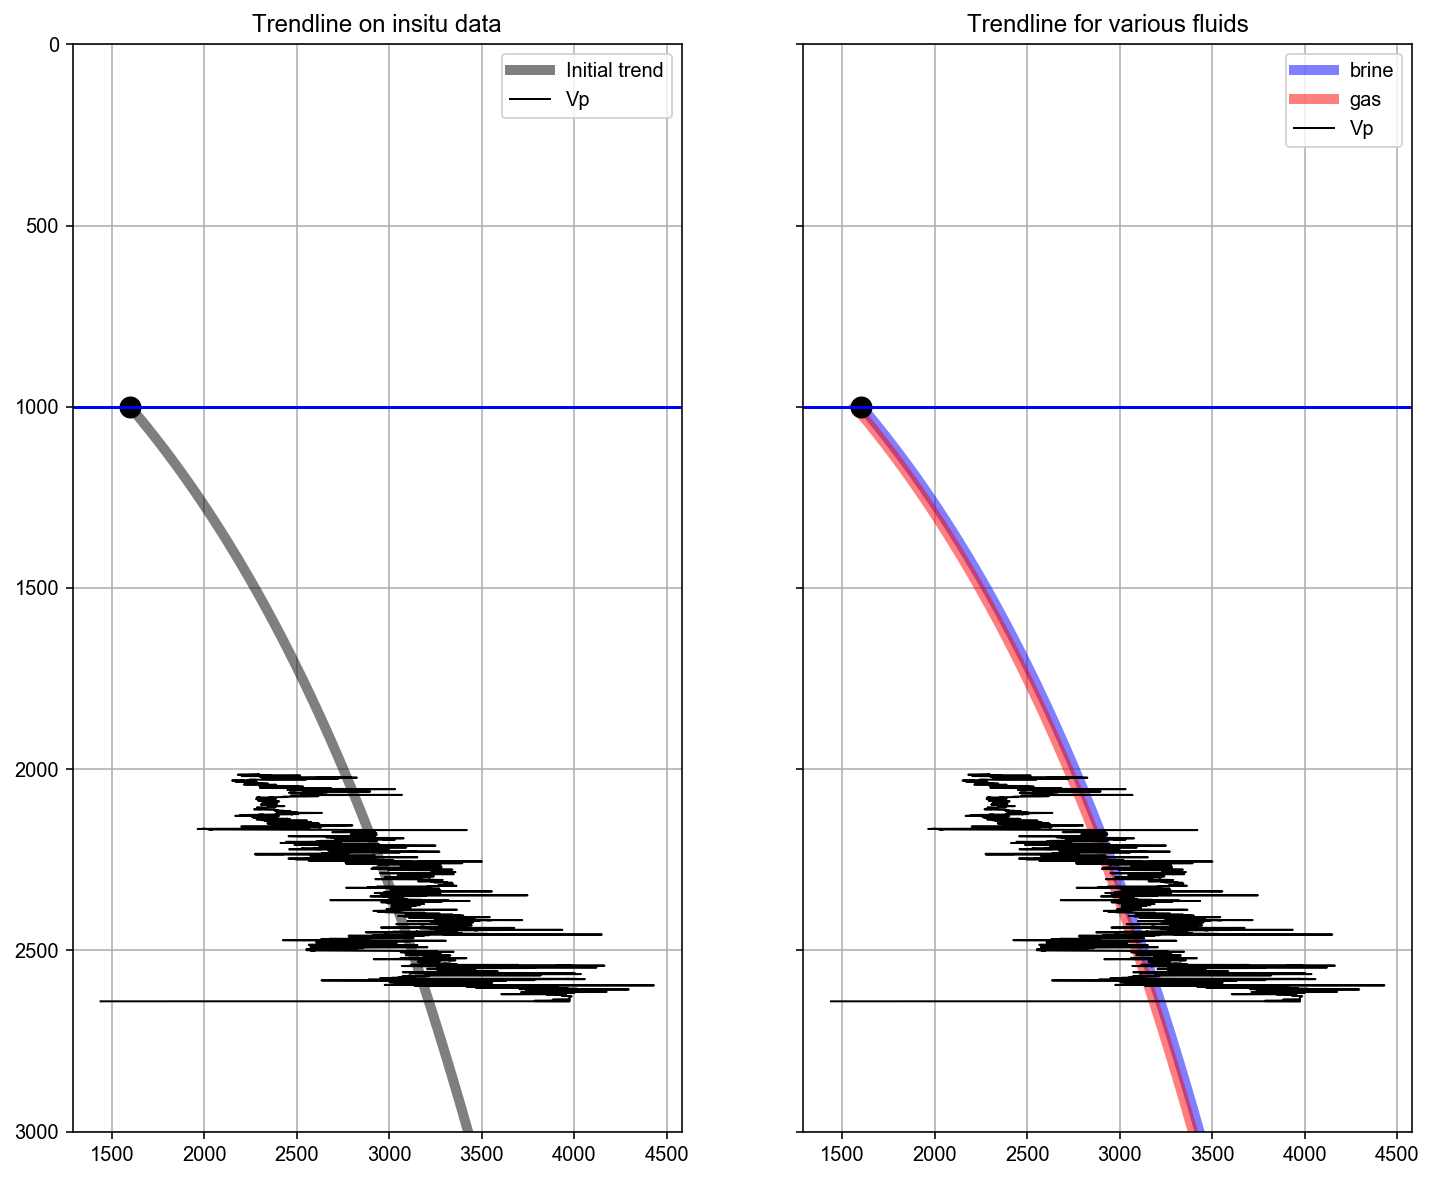

In [42]:
f, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(12,10))
ax[0].plot(trend, zfit, 'k', lw=5, alpha=0.5, label='Initial trend')

ax[1].plot(trend_brine, zfit, 'b', lw=5, alpha=0.5, label='brine')
ax[1].plot(trend_gas, zfit, 'r', lw=5, alpha=0.5, label='gas')

ax[0].set_title('Trendline on insitu data')
ax[1].set_title('Trendline for various fluids')
for aa in ax:
    aa.plot(vp,z,'k',lw=1,label='Vp')
    aa.plot(vp0,z0,'ko',ms=10)
    aa.set_ylim(3000,0)
    aa.axhline(y=z0, color='b')
    aa.legend(fontsize='medium')
    aa.grid()